Reference: Evidence of Predictable Behavior of Security Returns by N. Jegadeesh

First we configure the notebook to show plots inline and import necessary python packages.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt

# 1. Get data for backtesting

The period for backtesting is selected to be from 01/31/2000 to 12/31/2015. The data for backtesting were downloaded from Yahoo! Finance with publicly available python modules. All data are pre-downloaded and saved in CSV files, which is read and formatted using self-defined function

In [2]:
from my_helper_fn import read_from_csv

## Stock price data

In [3]:
price_csv = 'stock_adj_close_2000_2015.csv';
stock_prices = read_from_csv( price_csv );
monthly_stock_prices = stock_prices.resample( "BM" ).last();
monthly_stock_returns = monthly_stock_prices.pct_change().iloc[1:];

# Take a peek at the data
print monthly_stock_returns.iloc[:5,:5]

                   A        AA      AAPL       ABC       ABT
Date                                                        
2000-01-31 -0.143897 -0.160392  0.009118  0.193414 -0.098862
2000-02-29  0.569405 -0.013621  0.104819 -0.196553  0.013436
2000-03-31  0.001203  0.025547  0.184842  0.030045  0.066288
2000-04-28 -0.147837 -0.076512 -0.086516  0.333333  0.097843
2000-05-31 -0.169252 -0.095731 -0.322922  0.212500  0.058536


#### Looking-forward bias

The universe of stocks is selected to be all those stocks that have been in S&P500 since 2000 through 2015. This introduces looking-forward or survivorship bias, because only those stocks that manage to remain in S&P500 are kept. The number of stocks selected is a little more than 400, so an implied assumption is that this looking-forward bias can be ignored in our backtest.

## Benchmark: S&P 500

In [4]:
snp_500 = read_from_csv( "benchmark.csv" );
snp_500 = snp_500.resample( "BM" ).last();
snp_500_returns = snp_500.pct_change().iloc[1:];
benchmark_returns = snp_500_returns;

print benchmark_returns.iloc[:5,:];

               ^GSPC
Date                
1991-01-31  0.041518
1991-02-28  0.067281
1991-03-29  0.022203
1991-04-30  0.000320
1991-05-31  0.038605


## Risk-free rate: Rate of 13 WEEK TREASURY BILL

Raw data are annualized rates, and therefore it needs to be converted to monthly return in order to be compared with monthly stock and benchmark returns.

In [5]:
rf_annualized_rate = read_from_csv( "riskfree.csv", rescale_factor = 0.01 );
rf_annualized_rate = rf_annualized_rate.resample('BM').last();
def deannualization_func( annual_rate, freq="M" ):
	if freq is "M":
		return (1+annual_rate)**(1./12) - 1

rf_rate = rf_monthly_rate = rf_annualized_rate.apply( deannualization_func );
riskfree_rate = rf_rate;

print riskfree_rate.iloc[:5,:]

                ^IRX
Date                
1990-12-31  0.005214
1991-01-31  0.005018
1991-02-28  0.004899
1991-03-29  0.004662
1991-04-30  0.004480


# 2. Test the signal

A simple idea to test the signal: rank the universe based on the result of cross-sectional autogression results, and then pick the top 10 stocks to hold for the next period.

In [6]:
from myStrategies.regression import Regression_OLS  # A strategy that's based on OLS regression

lags = range(1,13);
reg_lags_and_weights = {};
for lag in lags:
	reg_lags_and_weights[ lag ] = 1;
    
ols_strategy = Regression_OLS( 
	stock_prices,
	riskfree_rate,
	benchmark_returns,
	resample_freq = "BM",
	sample_lookback = 60,			# number of periods of looking back for training data
	reg_lags_and_weights = reg_lags_and_weights,
	num_longs = 10,					# number of stocks to long for each period
	num_shorts = 0,				# number of stocks to short for each period
);

ols_backtest_res = ols_strategy.BackTest();


We can calculate various measures in order to evaluate how the strategy performs.In perticular, the strategy exhibits high beta.

In [7]:
_, ols_strategy_analysis = ols_strategy.BackTestAnalysis();
print ols_strategy_analysis;

{'Average Return': 0.011840291603954011, 'Sortino': 0.0717828038550333, 'CAMP': (0.0055861166124176178, 1.3332234514503363), 'Sharpe': 0.50016302860703432, 'Info_Ratio': 0.4711980150621804, 'Volatility': 0.076079602721381964}


### Drawdown

By plotting the cumulative return of the strategy, we noticed large drawdown during the financial crisis and recent market turmoil.

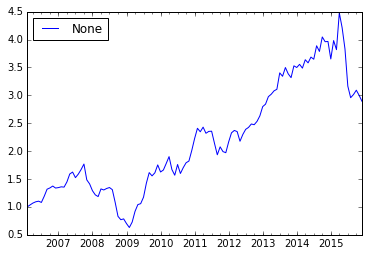

In [8]:
plt.figure();
ols_backtest_res[ "cum_strategy" ].plot( legend = True);

### Look into regression results

In Jagadeesh's paper, it was claimed that first order coefficient is in general negative. By plotting the regression coefficient, we do observe "abnormal" behavior from Jagadeesh's claim. We also plot the 95% confidence interval for each step to show its statistical significance.

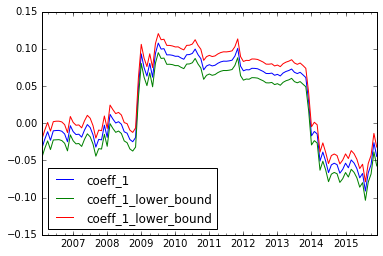

In [9]:
plt.figure();
ols_strategy.reg_coefficients_df.loc[:,"coeff_1"].plot( legend = True );

coeff1_lb_arr = list(); # Lower bound for 1st order regression coefficient
coeff1_ub_arr = list(); # Upper bound for 1st order regression coefficient
for reg_result in ols_strategy.reg_result_hist_df:
    coeff1_lb_arr.append( reg_result.conf_int()[1,0] );    
    coeff1_ub_arr.append( reg_result.conf_int()[1,1] );    

reg_result_index = ols_strategy.reg_result_hist_df.index;
coeff1_lb_series = pd.Series( coeff1_lb_arr, index=reg_result_index, name = "coeff_1_lower_bound" );
coeff1_ub_series = pd.Series( coeff1_ub_arr, index=reg_result_index, name = "coeff_1_lower_bound" );

coeff1_lb_series.plot( legend = True );
coeff1_ub_series.plot( legend = True );
                  

### Test on OLS assumptions

It is important to test the basic assumptions for OLS regression. Below I show the p-values for normality test and heteroskedasticity test. It looks like, with the above setting (a lookback window of 60 months), the OLS residual satisfies both assumptions on normality and heteroskedasticity.

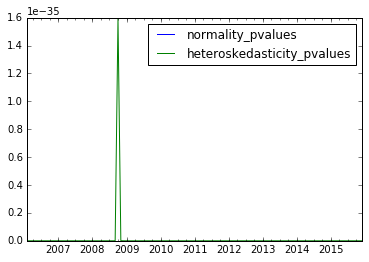

In [10]:
plt.figure();
ols_strategy.normality_pvalues_series.plot( legend=True );
ols_strategy.heteroskedasticity_pvalues_series.plot( legend=True );

### Questions / Issues / Improvements

1. Feature selections. Are all the selected lags for regression necessary? 
2. Dynamic adjust regression coefficients. How does the pre-determined lookback window of 60 months impact our prediction ability? 
3. How to avoid the large drawdown?

# Attempt on feature selection: Lasso